# 앙상블 모델
## 배깅, 부스팅, 스태킹
- 배깅: 데이터를 랜덤하게 (다양하게) 사용하는 것 (예 랜덤 포레스트)
- 부스팅: 모델을 순차적으로 개선하는 것 (예, xgboost, lightgbm)
- 스태킹: 여러 다양한 모델의 결과를 취합하는 것

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-05-29%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%208.49.26.png?raw=1" align='left' width=500>

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-05-29%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%208.53.39.png?raw=1" align='left' width=500>

# 배깅 앙상블
- "같은" 모델을 사용하고 데이터를 무작위로 달리 사용한다
- 배깅: 중복허용 (bootstrap aggregation)
- 페이스팅: 중복 불 허용
- 병렬로 처리할 수 있다
## (예)랜덤 포레스트: 배깅을 적용한 결정트리 앙상블 기법

### OOB 데이터 평가
- out of bagging
- 훈련에 사용되지 않는 37%의 데이터를 검증에 사용
- 선택되지 않을 확률: e**(-1)
- 선택될 확률: (1 - e**(-1))
- oob_score=True로 하면 자동으로 평가를 해준다 (검증 데이터를 따로 사용하지 않는다)

# 부스팅 알고리즘
## 에이다부스트 (adaptive boosting)
- 앞의 약한 모델을 보완해 나가는 앙상블 모델
- 이전 모델에서 과소적합했던 훈련 샘플의 가중치를 더 높여주는 것 (학습하기 어려운 샘플에 점점 더 맞춰진다)
- 잘 못 분류된 훈련 샘플의 가중치를 높인다, 두번째 분류기는 업데이트된 가중치를 사용하여 "예측기"를 만들어본다 (단계별로 채점을 해보는 것임)
- 경사하강법이 "손실함수"를 점차 줄이듯이, 에이다 부스트는 예측기를 만들어 "성능"이 좋아지도록 학습한다.
- 모든 예측기를 만든 이후에 배깅이나 페이스팅을 적용한다. 단 가중치가 적용된 정확도에 따라 예측기마다 다른 가중치를 적용한다
- 병렬처리는 안된다

<img src= "https://bit.ly/2zjphkA" width="500">

In [1]:
import os
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그라디언트 부스팅
- 에이다 부스트에서는 가중치를 수정하면서 성능을 개선하였다.
- 그라디언트 부스팅에서는 앞단계 모델의 "예측 오차"를 예측하는 모델을 만든다
- 즉, y가 아니라 e를 예측하는 모델을 계속 만드는 작업을 한다.
- 각 단계의 "간단한" 모델은 주로 결정트리를 사용한다

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# 샘플 데이터 생성
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100) 
# y = 3*x^2 + noise

In [4]:
X[:3]

array([[-0.12545988],
       [ 0.45071431],
       [ 0.23199394]])

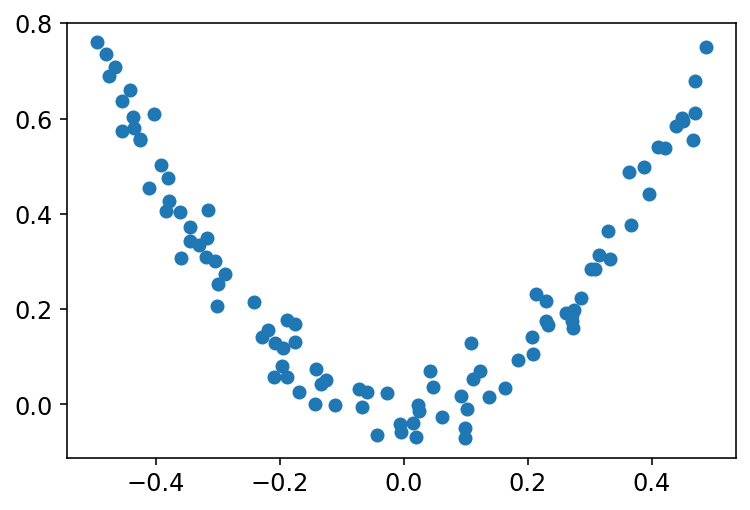

In [5]:
plt.scatter(X,y)

In [6]:
#  X -> y 예측기
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [7]:
# X -> e 예측기 (e는 오차)
e = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, e)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [8]:
# X -> e2 예측기 (e2는 오차의 오차)

e2 = e - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, e2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [9]:
X_sample = np.array([[0.3], [0], [-0.2]])

# 3개의 모델의 합을 구한다
y_pred = sum(tree.predict(X_sample) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred # y = 3*x^2

array([0.17052257, 0.04021166, 0.04021166])

## 과제: 샘플수, 노이지를 바꾸어 실행해본다

In [10]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

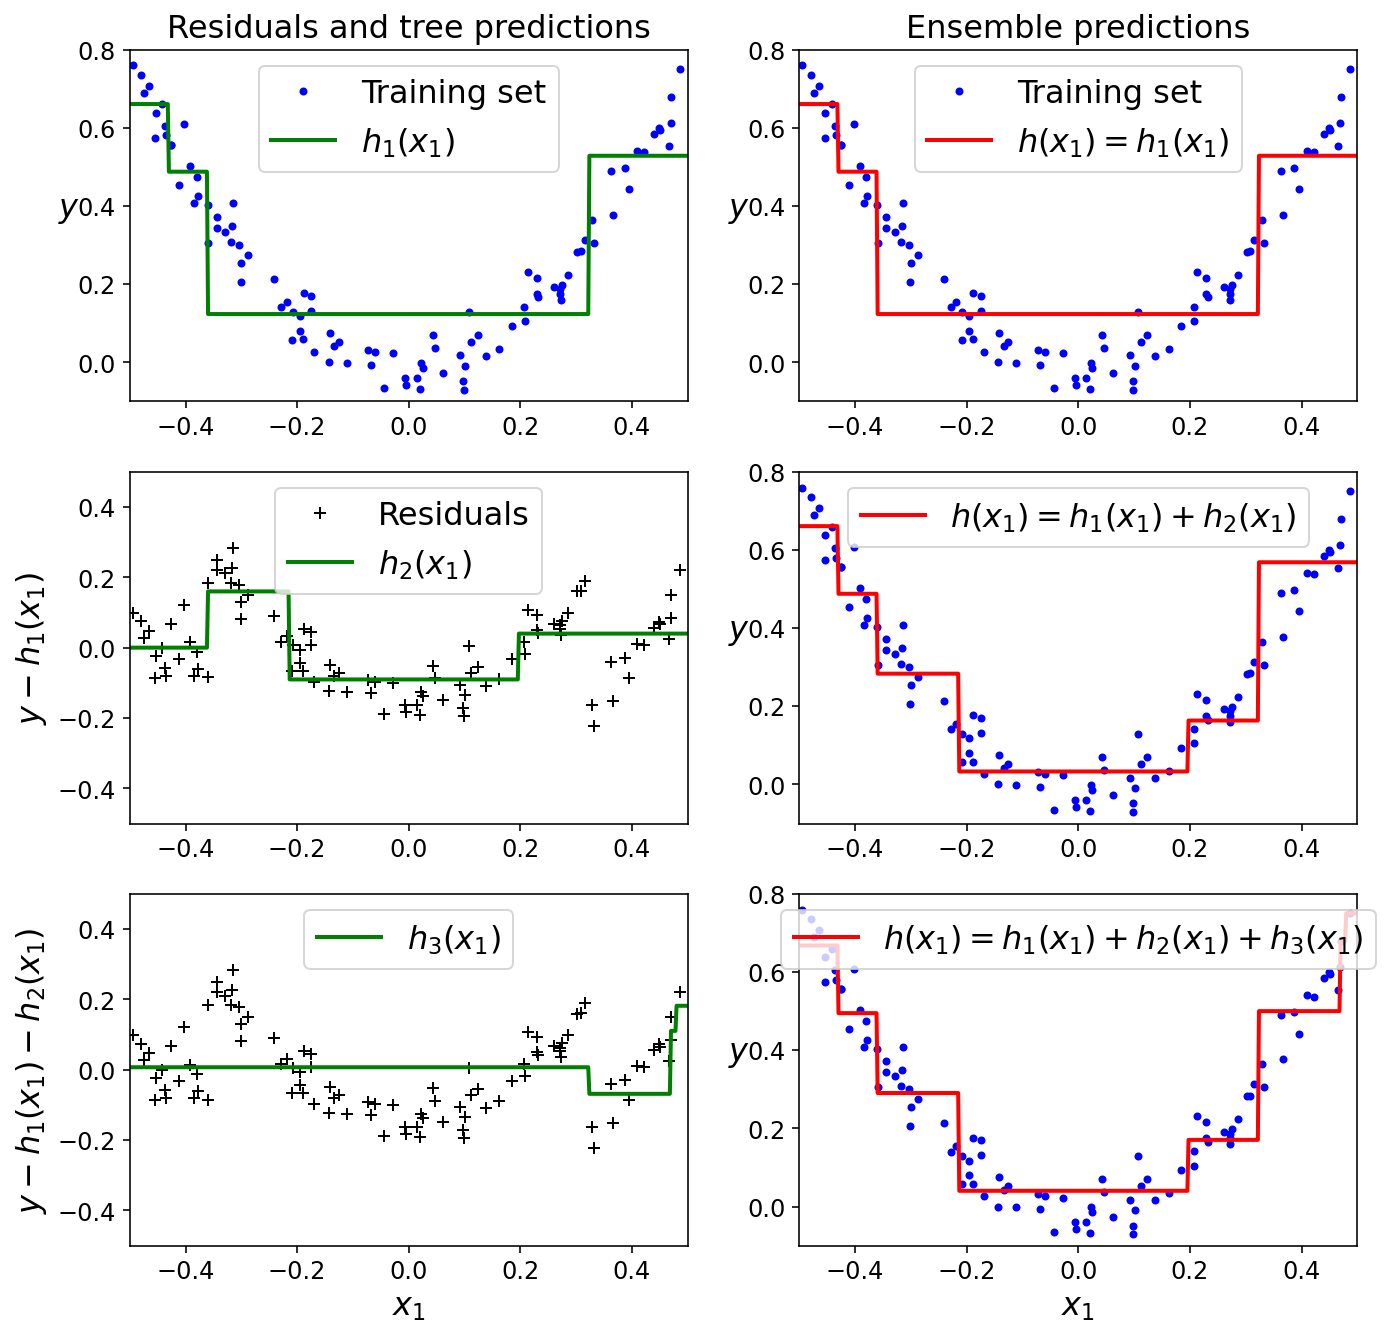

In [11]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
e = y - tree_reg1.predict(X)
plot_predictions([tree_reg2], X, e, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
e2 = y - tree_reg1.predict(X)
plot_predictions([tree_reg3], X, e2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# save_fig("gradient_boosting_plot")
plt.show()

- 좌측은 예측기의 순차적인 동작을 설명
- 우측은 앙상블의 예측 (합)을 보여준다

### 모델을 사용하는 예
- 하이퍼파라미터: 학습속도 (learning rate)

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [13]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.5, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(learning_rate=0.5, max_depth=2, random_state=42)

- 과소적합(적은 수의 트리 사용)과 과대적합과 (너무 많은 트리 사용)
- subsample 로 샘플을 취할 비율을 조정할 수 있다. 훈련 속도가 빨라진다 (확률적 그라디언트 부스팅)

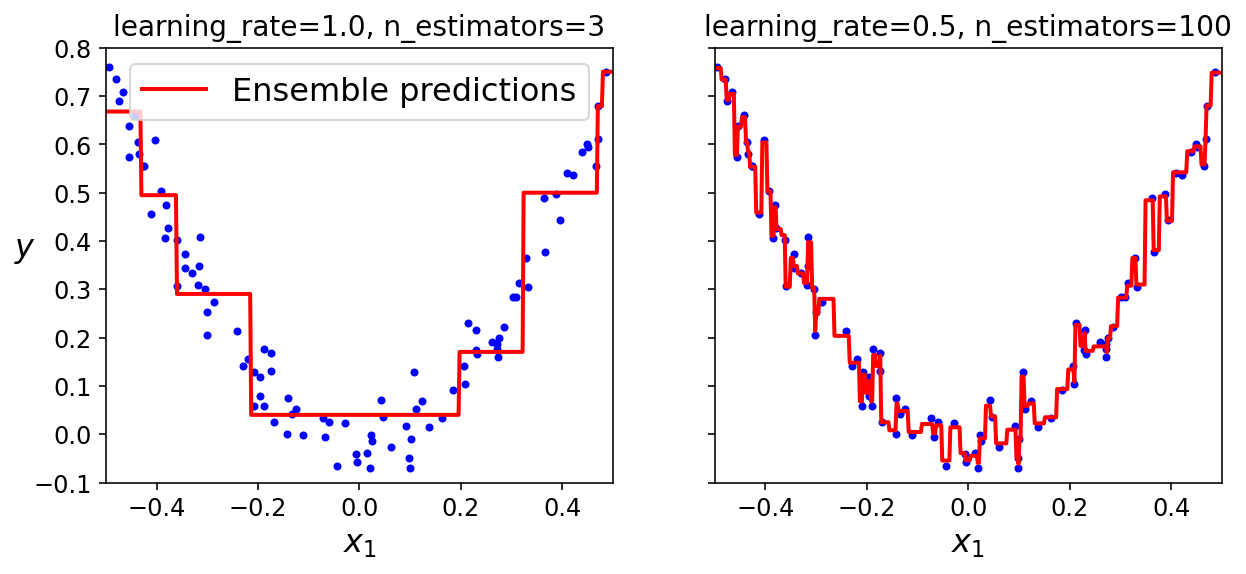

In [14]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

# save_fig("gbrt_learning_rate_plot")
plt.show()

## (과제) 모델 수와 학습속도를 바꾸어 본다

## 최적 성능 시점 찾기
- 검증 데이터를 사용한 staged_predict() 이용

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

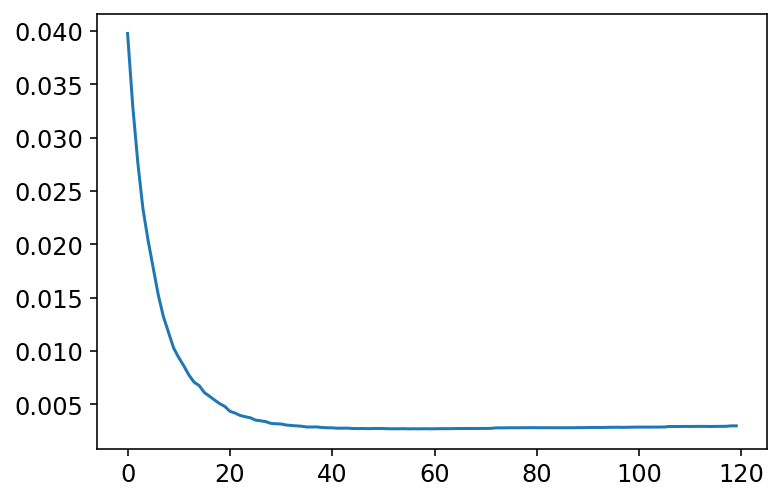

In [16]:
plt.plot(errors)

In [17]:
min_error = np.min(errors)

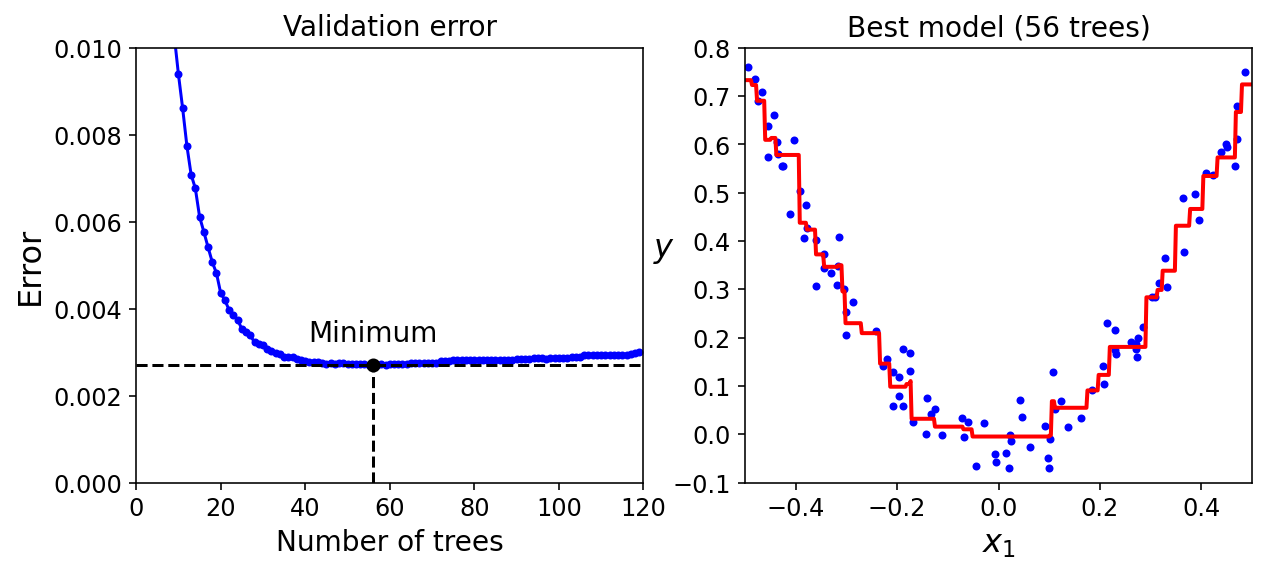

In [18]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

# save_fig("early_stopping_gbrt_plot")
plt.show()

## (참고) 조기종료 시점 찾기
- warm_start=True : 기존 트리를 유지하며 훈련을 추가할 수 있도록 한다
- 검증 오차 향상을 5회 기다린다 (종료전에)

In [19]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [20]:
print(gbrt.n_estimators)

61


In [21]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## XGBoost
- extreme gb

In [22]:
# !pip install xgboost

In [23]:
import xgboost

In [24]:
# 아래는 최적치가 아니다
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)          

Validation MSE: 0.004000408205406276


- 조기 종료 설정으로 최적치를 찾는다

In [25]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=5)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)           

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
[10]	validation_0-rmse:0.05338
[11]	validation_0-rmse:0.05417
Validation MSE: 0.002630868681577655


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

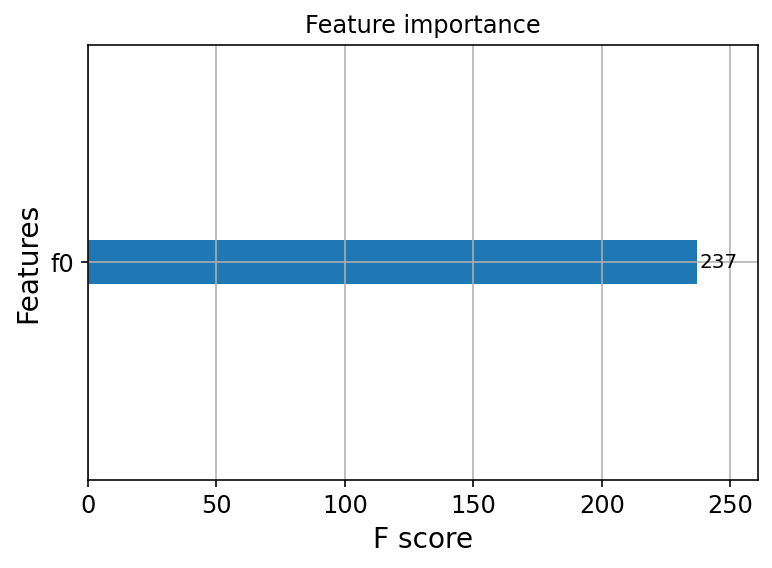

In [28]:
# 특성 중요도 (여기서는 특성이 하나임)
from xgboost import plot_importance
plot_importance(xgb_reg)

## XGBoost를 개선한 LightGBM 

# 투표기반 분류기
- 여러가지 모델을 사용하여 예측을 하고 각 결과를 취합하는 방법
- 직접 투표 또는 간접투표를 선택할 수 있다


## Two Moon Data

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.35, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
print(X_train.shape)
plt.scatter(X[:,0], X[:,1], c=y)

## 선형분류, 로지스틱회귀, 결정트리, kNN

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

lin_clf = SGDClassifier()
dt_clf = DecisionTreeClassifier()
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

## 직접 투표

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('linear', lin_clf),('dt', dt_clf),('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (lin_clf, dt_clf, log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

## 간접 투표
- SVC는 클래스 확률을 제공하지 않으므로 이를 얻으려면 명시적으로 probabbility=True를 지정해야 한다 (단, 클래스 확률을 구하기 위해서 교차검증을 해야 하고 속도는 느려진다)


In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('dt', dt_clf), ('lr', log_clf),('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (dt_clf, log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))